In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
from networks.self_supervised import SelfSupervisedCNN
import torch
from datasets.dataset_synapse import Synapse_dataset, RandomGenerator, NiiDataset, pretrain_dataset
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
import numpy as np
import torch
from tqdm import tqdm
from utils import test_single_volume, dice_coeff

In [43]:


def tensor_visualizer(tensor1, tensor2, tensor3):
    """
    一个生成器，每次对一个通道的两个张量进行可视化。
    
    参数:
    - tensor1: 第一个输入张量，尺寸为[32, 160, 160]。
    - tensor2: 第二个输入张量，同样尺寸为[32, 160, 160]。
    
    每次调用将针对下一个通道绘制tensor1和tensor2的对比图。
    """
    
    for channel in range(tensor1.shape[0]):
        # 对当前通道的张量绘图
        fig, axs = plt.subplots(1, 3, figsize=(8, 4))
        
        # 第一个张量的当前通道
        axs[0].imshow(tensor1[channel], cmap='gray')
        axs[0].set_title(f'prigin img - Channel {channel}')
        axs[0].axis('on')
        
        # 第二个张量的当前通道
        axs[1].imshow(tensor2[channel], cmap='gray')
        axs[1].set_title(f'rebuild img - Channel {channel}')
        axs[1].axis('on')

        print('dice: ', dice_coeff(torch.tensor(tensor1[channel]), torch.tensor(tensor2[channel]),False))

        # 第二个张量的当前通道
        axs[2].imshow(tensor3[channel], cmap='gray')
        axs[2].set_title(f'mask - Channel {channel}')
        axs[2].axis('on')
        
        plt.tight_layout()
        plt.show()
        
        yield  # 暂停执行，直到下一次调用

# 一、草稿

In [2]:
import numpy as np

In [2]:
data = np.load('/home/peijia/TransUNet/case0005_slice000.npz')
image, label = data['image'], data['label']

In [3]:
image.shape

(512, 512)

In [4]:
label.shape

(512, 512)

In [13]:
image.dtype

dtype('float32')

In [14]:
label.dtype

dtype('float32')

In [16]:
unique_values, counts = np.unique(label, return_counts=True)

In [18]:
counts

array([262144])

In [7]:
a = open('/home/peijia/medical_dataset/train_img_1.txt').readlines()

In [20]:
name = a[0]

In [21]:
name.strip('\n')

'0865_image.nii.gz'

In [10]:
b = open('/home/peijia/medical_dataset/train_mask_1.txt').readlines()

In [11]:
b[0]

'0865_mask_1.nii.gz\n'

In [12]:
[1]+[2]

[1, 2]

In [23]:
import SimpleITK as sitk

In [25]:
img = sitk.ReadImage(str('/home/peijia/medical_dataset/image/0852_image.nii.gz'))
a = sitk.GetArrayFromImage(img)


In [26]:
a.shape

(17, 512, 512)

In [27]:
a[1].shape

(512, 512)

In [3]:
arr = np.ones([19, 512, 512])

In [4]:
import torch
arr = torch.tensor(arr)

/home/peijia/miniconda3/envs/medical/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
h, w = arr.size()[1:]

In [9]:
h

512

# 二、验证重建效果

In [1]:


pretrain_model = SelfSupervisedCNN()
pretrain_model.load_state_dict(torch.load('/home/peijia/TransUNet/networks/compatible_pretrain.pth'))
pretrain_model.cuda()

/home/peijia/miniconda3/envs/medical/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SelfSupervisedCNN(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (1): ReLU()
    (2): ConvTranspose3d(32, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (3): Sigmoid()
  )
)

In [3]:
split_path = '/home/peijia/medical_dataset/'
split_list = ['train_img_1.txt', 'train_img_2.txt', 'train_img_3.txt', 'train_img_4.txt']
for i, file_name in enumerate(split_list):
    split_list[i] = split_path + file_name
db_train = pretrain_dataset(None, '/home/peijia/medical_dataset/image', '/home/peijia/medical_dataset/mask', split_list, split="train")
def worker_init_fn(worker_id):
    random.seed(1234 + worker_id)
trainloader = DataLoader(db_train, batch_size=1, shuffle=True, num_workers=8, pin_memory=True,
                             worker_init_fn=worker_init_fn)



Creating train NiiDataset with 680 examples


100%|██████████| 32/32 [00:04<00:00,  7.48it/s]

num_not_32:  1


In [4]:
for sampled_batch in trainloader:
    image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
    image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
    break

In [5]:
pretrain_model.eval()
outputs = pretrain_model(image_batch)

In [6]:
outputs=outputs.detach().squeeze(0).squeeze(0)
image_batch=image_batch.squeeze(0).squeeze(0)
label_batch=label_batch.squeeze(0).squeeze(0)

In [7]:
torch.nn.functional.mse_loss(image_batch, outputs)

tensor(0.0988, device='cuda:0')

In [9]:
visualizer = tensor_visualizer(image_batch.cpu().numpy(), outputs.cpu().numpy(), label_batch.cpu().numpy())

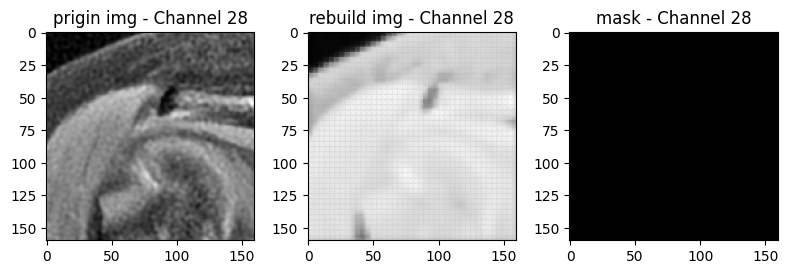

In [45]:
next(visualizer)

In [11]:
sampled_batch['bbox']

[tensor([3]),
 tensor([12]),
 tensor([97]),
 tensor([252]),
 tensor([104]),
 tensor([259])]

问题：为什么看起来差别较大，但是mse的值这么小？
可能是归一化的问题？(np_image) / np.max(np_image)，目前只是超级简单的归一化

In [11]:
def gen():
    img_batch = sampled_batch['origin'].squeeze(0).squeeze(0)
    for i in range(img_batch.shape[0]):
        img = img_batch[i]
        plt.figure(figsize=(6, 6))
        plt.imshow(img, cmap='gray')
        yield
a = gen()

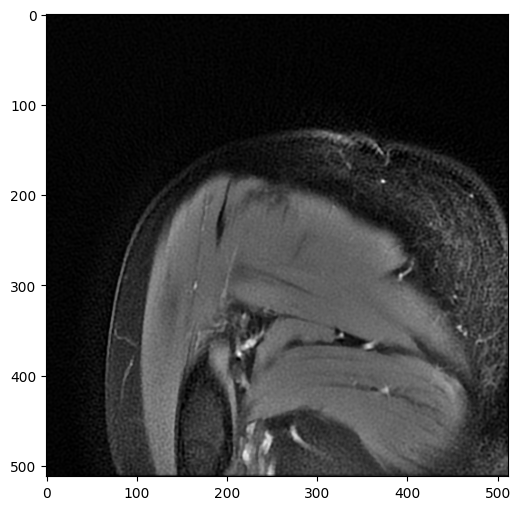

In [12]:
next(a)

这个数据集甚至进行了裁剪处理，目前是根据真值的mask进行裁剪后，进行细分割

# 三、检验完整图像的dice

In [4]:


split_path='/home/peijia/medical_dataset/'
split_list=['test_img.txt']
from datasets.dataset_synapse import NiiDataset, pretrain_dataset
for i, file_name in enumerate(split_list):
    split_list[i] = split_path + file_name
db_test = pretrain_dataset(None, '/home/peijia/medical_dataset/image', '/home/peijia/medical_dataset/mask', split_list, split="test")
testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=1)

Creating test NiiDataset with 214 examples


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

num_not_32:  0


In [5]:


config_vit = CONFIGS_ViT_seg['R50-ViT-B_16']
config_vit.n_classes = 2
config_vit.n_skip = 3
config_vit.patches.grid = (int(160 / 16), int(160 / 16))
net = ViT_seg(config_vit, img_size=160, num_classes=2).cuda()
net.load_from(weights=np.load(config_vit.pretrained_path))
net.load_state_dict(torch.load('/home/peijia/TransUNet/pretrain_complete/epoch_149.pth'))

load_pretrained: grid-size from 14 to 10


<All keys matched successfully>

In [68]:
net.eval()
len_slices = 0

for i_batch, sampled_batch in enumerate(testloader):
    # image: [bs, 1, 32, 160, 160]
    # label: [bs, 1, 32, 160, 160]
    
        # 要点1：大小要一样
        # 要点2：为什么这里要指定args.img_size，不指定会进行缩放
    

    image = sampled_batch["image"]
    label = sampled_batch["origin_mask"]
    bbox = sampled_batch["bbox"]
    # print('image size(): ', image.shape)
    len_slices += label.shape[1]

    metric_i, pred, mask = test_single_volume(image, label, net, classes=2, patch_size=[160, 160],
                                test_save_path=None, case=None, bbox=bbox)
    break

In [44]:
origin_img = sampled_batch["origin"].squeeze(0).squeeze(0).cpu().detach().numpy()
visualizer = tensor_visualizer(pred, mask, origin_img)

In [64]:
origin_img.shape

(16, 512, 512)

In [61]:
next(visualizer)

StopIteration: 